# COVID-19 and Weather Patterns

## Imports

- *os* for interfacing with the operating system
- *pathlib* for interfacing with the file system
- *zipfile* for managing archive files

- *numpy* for array processing
- *pandas* for tabular processing
- *tensorflow* for tensor processing
- *keras* for simplified tensor processing

- *matplotlib* for visualization
- *seaborn* for enhanced visualization

In [1]:
# Custom
import data_processing

# File System
import os
import json
from pathlib import Path
from zipfile import ZipFile

# Processing
import numpy as np
import pandas as pd
from sympy import *
from sympy.geometry import *
import tensorflow
from tensorflow import keras

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

tensorflow.__version__

'2.7.0'

## Introduction

The goal of this work is to determine whether or not weather patterns should be considered as a meaningful supporting input when making predictions about new daily COVID-19 cases within a given geographical space. Using census, weather, and COVID-19 datasets provided by the Urban Sustain project, the authors attempt to quantify the correlation between particular weather patterns and COVID-19 transmission events.

## Defining Terms

***Urban Sustain Project*** - A joint effort between researchers at Colorado State University, Arizona State University, the University of California-Irvine, and the University of Maryland – Baltimore County.

## Loading Data

**DEVELOPER NOTE:** Download the five required datasets from Urban Sustain and place them in the cloned repository at ```./data/```. These datasets are also available at a shared OneDrive folder. This logic expects that these files exist at relative path ```../data/``` with respect to this notebook.

We'll begin by defining a path to our data directory and a list of the datasets that we expect to find there.

In [2]:
DATA_PATH = '../data/' # Point this constant to the location of your data archive files

EXPECTED_DATASETS = [
    'county_total_population.Colorado.zip',
    'covid_county.Colorado.zip',
    'neon_2d_wind.Colorado.zip',
    'neon_barometric_pressure.Colorado.zip',
    'neon_single_asp_air_temperature.Colorado.zip'
]

Next, we will attempt to extract each of these archived datasets into a dedicated subdirectory within the given data directory.

In [3]:
# For each listed dataset string in the EXPECTED_DATASETS constant
for datasetName in EXPECTED_DATASETS:
    try:
        # Open the given archive file
        with ZipFile(DATA_PATH + datasetName, 'r') as currentZip:
            # Build the target directory path for extracted data
            datasetNameTokens = datasetName.split('.')
            datasetNameTokens.remove('zip')
            targetDirectory = DATA_PATH + '.'.join(datasetNameTokens)
            
            # If the target directory doesn't exist, create it
            if not os.path.exists(targetDirectory):
                Path(targetDirectory).mkdir()
            
            # Extract all data from the archive file to the target directory
            currentZip.extractall(targetDirectory)
    except FileNotFoundError:
        print("Unable to open " + datasetName + " at path " + DATA_PATH + datasetName)

## File Information

Four of the five datasets referenced in this work relate geospatial information to particular events as they occur over time Each is provided by the Urban Sustain project and employs a similar file structure.

- data.json
- fieldLabels.json
- linkedGeometry.json
- README.txt


#### New York Times COVID-19 County Dataset

The included COVID-19 County dataset 

In [4]:
covidDataFrame = pd.io.json.read_json('../data/covid_county.Colorado/data.json')
covidDataFrame.sample(5)

,_id,GISJOIN,epoch_time,dateString,county,state,totalCaseCount,newCaseCount,totalDeathCount,newDeathCount
29083,{'$oid': '615fc627bf06594c4cadb2f9'},G0800910,{'$numberLong': '1589868000000'},5/19/20,Ouray,Colorado,7,0,1,0
22313,{'$oid': '615fc626bf06594c4cad9a08'},G0800690,{'$numberLong': '1631167200000'},9/9/21,Larimer,Colorado,32741,111,264,0
26397,{'$oid': '615fc626bf06594c4cada96b'},G0800830,{'$numberLong': '1594015200000'},7/6/20,Montezuma,Colorado,74,1,3,0
32558,{'$oid': '615fc627bf06594c4cadc540'},G0801030,{'$numberLong': '1616911200000'},3/28/21,Rio Blanco,Colorado,516,1,4,0
5393,{'$oid': '615fc624bf06594c4cad57fb'},G0800150,{'$numberLong': '1625724000000'},7/8/21,Chaffee,Colorado,1780,1,25,0


In [5]:
covidLabelsFrame = pd.io.json.read_json('../data/covid_county.Colorado/fieldLabels.json')
covidLabelsFrame.sample(5)

,name,label
1,newDeathCount,New Death Count
2,totalDeathCount,Total Death Count
3,newCaseCount,New Case Count
0,epoch_time,Date
4,totalCaseCount,Total Case Count


In [6]:
covidGeometryFrame = pd.io.json.read_json('../data/covid_county.Colorado/linkedGeometry.json')
covidGeometryFrame.sample(5)

,_id,type,geometry,properties,GISJOIN
21,{'$oid': '604964eefed2e95d6b68bb12'},Feature,"{'type': 'Polygon', 'coordinates': [[[-104.662...","{'STATEFP10': '08', 'COUNTYFP10': '041', 'COUN...",G0800410
58,{'$oid': '604964ecfed2e95d6b68b67e'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.621...","{'STATEFP10': '08', 'COUNTYFP10': '115', 'COUN...",G0801150
2,{'$oid': '604964eefed2e95d6b68bb16'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '005', 'COUN...",G0800050
60,{'$oid': '604964eefed2e95d6b68b840'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.329...","{'STATEFP10': '08', 'COUNTYFP10': '119', 'COUN...",G0801190
25,{'$oid': '604964eefed2e95d6b68b849'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.854...","{'STATEFP10': '08', 'COUNTYFP10': '049', 'COUN...",G0800490


#### NEON 2D Wind Dataset

In [7]:
windDataFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/data.json')
windDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,windSpeedMean,windSpeedMinimum,windSpeedMaximum,windSpeedVariance,windSpeedNumPts,windSpeedExpUncert,windSpeedStdErMean,windSpeedFinalQF,windDirMean,windDirVariance,windDirNumPts,windDirExpUncert,windDirStdErMean,windDirFinalQF
236694,{'$oid': '60cbc08051c1683b462b2e87'},CPER_DP1.00001.001_000.010,{'$numberLong': '1542983400000'},2018-11-23T14:30:00Z,2018-11-23T15:00:00Z,2.63,0.45,7.27,1.35,1795,0.22,0.03,0,299.06,437.22,1795,0.07,0.01,0
750966,{'$oid': '60cbc28d51c1683b46642e8a'},RMNP_DP1.00001.001_000.010,{'$numberLong': '1529060400000'},2018-06-15T11:00:00Z,2018-06-15T11:30:00Z,0.93,0.00,4.94,0.36,1800,0.10,0.01,0,118.64,4400.10,1800,0.07,0.04,1
1053473,{'$oid': '60cbc28a51c1683b4663e3d2'},RMNP_DP1.00001.001_000.040,{'$numberLong': '1518294600000'},2018-02-10T20:30:00Z,2018-02-10T21:00:00Z,7.64,7.23,8.05,0.34,2,0.27,0.41,1,301.54,74.28,2,0.07,0.15,1
850145,{'$oid': '60cbc28e51c1683b46645f8c'},RMNP_DP1.00001.001_000.020,{'$numberLong': '1533612600000'},2018-08-07T03:30:00Z,2018-08-07T04:00:00Z,0.40,0.00,1.78,0.06,1800,0.04,0.01,0,267.85,1835.57,1800,0.07,0.02,1
436476,{'$oid': '60cbc07151c1683b46297db9'},CPER_DP1.00001.001_000.030,{'$numberLong': '1472180400000'},2016-08-26T03:00:00Z,2016-08-26T03:30:00Z,2.14,1.68,2.96,0.04,1800,0.06,0.00,0,220.20,64.62,1800,0.07,0.00,1


In [8]:
windLabelsFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/fieldLabels.json')
windLabelsFrame.sample(5)

,name,label
56,windDirAlphaQM,Wind direction quality metric detailing the ou...
30,windSpeedCalmWindQF,Wind speed quality flag for the calm wind test...
31,windSpeedFinalQF,Wind speed quality flag indicating whether a d...
29,windSpeedBetaQM,Wind speed quality metric detailing the outcom...
40,windDirPersistenceNAQM,Wind direction quality metric that summarizes ...


In [9]:
windGeometryFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/linkedGeometry.json')
windGeometryFrame.sample(5)

,_id,type,geometry,properties,site
9,{'$oid': '60cbcf5eed5577c25c20520d'},Feature,"{'type': 'Point', 'coordinates': [-104.74559, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC100245',...",CPER_DP1.00001.001_000.030
2,{'$oid': '60cbcf5eed5577c25c205231'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.020', 'name': 'CFGLOC100669',...",RMNP_DP1.00001.001_000.020
11,{'$oid': '60cbcf5eed5577c25c20520a'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC100115',...",STER_DP1.00001.001_000.030
10,{'$oid': '60cbcf5eed5577c25c20520b'},Feature,"{'type': 'Point', 'coordinates': [-104.74559, ...","{'HOR.VER': '000.010', 'name': 'CFGLOC100239',...",CPER_DP1.00001.001_000.010
14,{'$oid': '60cbcf5eed5577c25c205268'},Feature,"{'type': 'Point', 'coordinates': [-102.450966,...","{'HOR.VER': '200.000', 'name': 'CFGLOC101251',...",ARIK_DP1.00001.001_200.000


#### NEON Barometric Pressure Dataset

In [10]:
pressureDataFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/data.json')
pressureDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,staPresMean,staPresMinimum,staPresMaximum,staPresVariance,staPresNumPts,staPresExpUncert,staPresStdErMean,staPresFinalQF,corPres,corPresExpUncert,corPresFinalQF
271926,{'$oid': '60c78c2dc8cb4f3f3b0dff6c'},NIWO_DP1.00004.001,{'$numberLong': '1572512400000'},2019-10-31T09:00:00Z,2019-10-31T09:30:00Z,66.24472,66.21922,66.25921,0.00007,180,0.04731,0.00060,0,102.71360,0.76479,0
179413,{'$oid': '60c78b10c8cb4f3f3bed598a'},CPER_DP1.00004.001,{'$numberLong': '1518334200000'},2018-02-11T07:30:00Z,2018-02-11T08:00:00Z,83.12343,83.10980,83.13985,0.00007,180,0.01725,0.00063,0,103.54703,0.19245,0
66447,{'$oid': '60c78ab2c8cb4f3f3be26e0f'},ARIK_DP1.00004.001,{'$numberLong': '1615395600000'},2021-03-10T17:00:00Z,2021-03-10T17:30:00Z,87.16880,87.16241,87.18242,0.00003,180,0.04729,0.00040,0,100.64701,0.10313,0
201367,{'$oid': '60c78b13c8cb4f3f3bedafd1'},CPER_DP1.00004.001,{'$numberLong': '1559599200000'},2019-06-03T22:00:00Z,2019-06-03T22:30:00Z,83.23407,83.15511,83.30514,0.00163,180,0.01822,0.00301,0,101.04994,0.15171,0
49995,{'$oid': '60c78ab0c8cb4f3f3be22d66'},ARIK_DP1.00004.001,{'$numberLong': '1584478800000'},2020-03-17T21:00:00Z,2020-03-17T21:30:00Z,87.74194,87.71766,87.76767,0.00013,180,0.04733,0.00086,0,101.25938,0.10421,0


In [11]:
pressureLabelsFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/fieldLabels.json')
pressureLabelsFrame.sample(5)

,name,label
23,staPresGapPassQM,Station pressure quality metric that summarize...
33,staPresFinalQF,Station pressure quality flag indicating wheth...
11,staPresRangePassQM,Station pressure quality metric that summarize...
22,staPresGapFailQM,Station pressure quality metric that summarize...
34,staPresFinalQFSciRvw,Station pressure quality flag indicating wheth...


In [12]:
pressureGeometryFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/linkedGeometry.json')
pressureGeometryFrame.sample(5)

,_id,type,geometry,properties,site
1,{'$oid': '60c78a9d230c7f49850c20ef'},Feature,"{'type': 'Point', 'coordinates': [-105.914674,...","{'site': 'WLOU_DP1.00004.001', 'name': 'neon_b...",WLOU_DP1.00004.001
2,{'$oid': '60c78a9d230c7f49850c20b0'},Feature,"{'type': 'Point', 'coordinates': [-105.544602,...","{'site': 'COMO_DP1.00004.001', 'name': 'neon_b...",COMO_DP1.00004.001
3,{'$oid': '60c78a9d230c7f49850c20cf'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'site': 'NIWO_DP1.00004.001', 'name': 'neon_b...",NIWO_DP1.00004.001
5,{'$oid': '60c78a9d230c7f49850c20e3'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'site': 'STER_DP1.00004.001', 'name': 'neon_b...",STER_DP1.00004.001
4,{'$oid': '60c78a9d230c7f49850c20b1'},Feature,"{'type': 'Point', 'coordinates': [-104.74559, ...","{'site': 'CPER_DP1.00004.001', 'name': 'neon_b...",CPER_DP1.00004.001


#### NEON Air Temperature

In [13]:
temperatureDataFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/data.json')
temperatureDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,tempSingleMean,tempSingleMinimum,tempSingleMaximum,tempSingleVariance,tempSingleNumPts,tempSingleExpUncert,tempSingleStdErMean,finalQF
1085101,{'$oid': '60cbd39b0fc3818c81d97439'},STER_DP1.00002.001_000.020,{'$numberLong': '1439780400000'},2015-08-17T03:00:00Z,2015-08-17T03:30:00Z,19.8068,19.6298,19.9434,0.0066,1800,0.1429,0.0019,0
357284,{'$oid': '60cbd3bf0fc3818c81dda07c'},CPER_DP1.00002.001_000.030,{'$numberLong': '1406318400000'},2014-07-25T20:00:00Z,2014-07-25T20:30:00Z,30.0246,29.3282,31.0301,0.1571,1800,0.1486,0.0093,0
309974,{'$oid': '60cbd3d00fc3818c81dfcb5e'},CPER_DP1.00002.001_000.020,{'$numberLong': '1549571400000'},2019-02-07T20:30:00Z,2019-02-07T21:00:00Z,-13.7021,-14.2523,-12.3019,0.2039,1800,0.1307,0.0106,0
783624,{'$oid': '60cbd5450fc3818c810c1d07'},RMNP_DP1.00002.001_000.020,{'$numberLong': '1612432800000'},2021-02-04T10:00:00Z,2021-02-04T10:30:00Z,-9.3901,-9.7422,-8.9269,0.0286,1800,0.1333,0.0040,0
411835,{'$oid': '60cbd3d60fc3818c81e0696d'},CPER_DP1.00002.001_000.030,{'$numberLong': '1573961400000'},2019-11-17T03:30:00Z,2019-11-17T04:00:00Z,0.9914,0.2512,1.4769,0.0653,1800,0.1351,0.0060,0


In [14]:
temperatureLabelsFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/fieldLabels.json')
temperatureLabelsFrame.sample(5)

,name,label
7,tempSingleNumPts,Number of points used to calculate the arithme...
32,heaterPassQM,Quality metric that summarizes when the heater...
12,rangeNAQM,Quality metric that summarizes when the range ...
25,spikeFailQM,Quality metric that summarizes the failed outc...
18,stepNAQM,Quality metric that summarizes when the step t...


In [15]:
temperatureGeometryFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/linkedGeometry.json')
temperatureGeometryFrame.sample(5)

,_id,type,geometry,properties,site
0,{'$oid': '60cbd3907adbc5ff35cc41cb'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.030', 'name': 'CFGLOC100671',...",RMNP_DP1.00002.001_000.030
14,{'$oid': '60cbd3907adbc5ff35cc41a2'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.020', 'name': 'CFGLOC100017',...",STER_DP1.00002.001_000.020
13,{'$oid': '60cbd3907adbc5ff35cc41a3'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC100018',...",STER_DP1.00002.001_000.030
1,{'$oid': '60cbd3907adbc5ff35cc41ca'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.020', 'name': 'CFGLOC100668',...",RMNP_DP1.00002.001_000.020
12,{'$oid': '60cbd3907adbc5ff35cc41a1'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.010', 'name': 'CFGLOC100016',...",STER_DP1.00002.001_000.010


### U.S. Census Total County Population Dataset

In [16]:
populationDataFrame = pd.io.json.read_json('../data/county_total_population.Colorado/data.json')
populationDataFrame

,_id,GISJOIN,STATE,STATEFP,STATENH,COUNTY,COUNTYFP,COUNTYNH,1980_total_population,1990_total_population,2000_total_population,2010_total_population
0,{'$oid': '607d4c2708e81eceb6b6e384'},G0800010,Colorado,8,80,Adams County,1,10,245944,265038,363857,441603
1,{'$oid': '607d4c2708e81eceb6b6e385'},G0800030,Colorado,8,80,Alamosa County,3,30,11799,13617,14966,15445
2,{'$oid': '607d4c2708e81eceb6b6e386'},G0800050,Colorado,8,80,Arapahoe County,5,50,293621,391511,487967,572003
3,{'$oid': '607d4c2708e81eceb6b6e387'},G0800070,Colorado,8,80,Archuleta County,7,70,3664,5345,9898,12084
4,{'$oid': '607d4c2708e81eceb6b6e388'},G0800090,Colorado,8,80,Baca County,9,90,5419,4556,4517,3788
...,...,...,...,...,...,...,...,...,...,...,...,...
58,{'$oid': '607d4c2708e81eceb6b6e3bf'},G0801170,Colorado,8,80,Summit County,117,1170,8848,12881,23548,27994
59,{'$oid': '607d4c2708e81eceb6b6e3c4'},G0801190,Colorado,8,80,Teller County,119,1190,8034,12468,20555,23350
60,{'$oid': '607d4c2708e81eceb6b6e3c3'},G0801210,Colorado,8,80,Washington County,121,1210,5304,4812,4926,4814
61,{'$oid': '607d4c2708e81eceb6b6e3c2'},G0801230,Colorado,8,80,Weld County,123,1230,123438,131821,180936,252825


In [17]:
populationLabelsFrame = pd.io.json.read_json('../data/county_total_population.Colorado/fieldLabels.json')
populationLabelsFrame

""


In [18]:
populationGeometryFrame = pd.io.json.read_json('../data/county_total_population.Colorado/linkedGeometry.json')
populationGeometryFrame

,_id,type,geometry,properties,GISJOIN
0,{'$oid': '604964ecfed2e95d6b68b676'},Feature,"{'type': 'Polygon', 'coordinates': [[[-104.961...","{'STATEFP10': '08', 'COUNTYFP10': '001', 'COUN...",G0800010
1,{'$oid': '604964ecfed2e95d6b68b684'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.457...","{'STATEFP10': '08', 'COUNTYFP10': '003', 'COUN...",G0800030
2,{'$oid': '604964eefed2e95d6b68bb16'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '005', 'COUN...",G0800050
3,{'$oid': '604964eefed2e95d6b68b9c8'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.128...","{'STATEFP10': '08', 'COUNTYFP10': '007', 'COUN...",G0800070
4,{'$oid': '604964eefed2e95d6b68b83d'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.747...","{'STATEFP10': '08', 'COUNTYFP10': '009', 'COUN...",G0800090
...,...,...,...,...,...
59,{'$oid': '604964ecfed2e95d6b68b677'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.924...","{'STATEFP10': '08', 'COUNTYFP10': '117', 'COUN...",G0801170
60,{'$oid': '604964eefed2e95d6b68b840'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.329...","{'STATEFP10': '08', 'COUNTYFP10': '119', 'COUN...",G0801190
61,{'$oid': '604964eefed2e95d6b68b9c5'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.779...","{'STATEFP10': '08', 'COUNTYFP10': '121', 'COUN...",G0801210
62,{'$oid': '604964eefed2e95d6b68b9c3'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '123', 'COUN...",G0801230


## Data Exploration

c:\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='newCaseCount', ylabel='Density'>

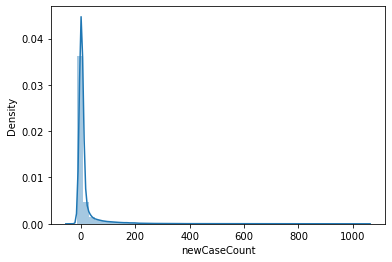

In [19]:
sns.distplot(covidDataFrame.newCaseCount)

c:\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tempSingleMean', ylabel='Density'>

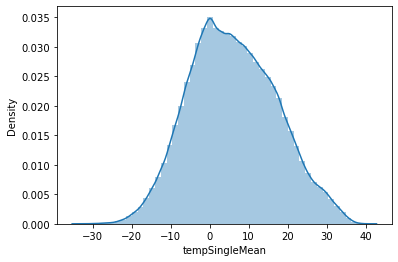

In [20]:
sns.distplot(temperatureDataFrame.tempSingleMean)

## Preprocessing

#### Flatten Frames

In [21]:
flattenedCovidDataFrame = pd.json_normalize(json.load(open(Path('../data/covid_county.Colorado/data.json'))))
flattenedCovidGeometryFrame = pd.json_normalize(json.load(open(Path('../data/covid_county.Colorado/linkedGeometry.json'))))

flattenedWindDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_2d_wind.Colorado/data.json'))))
flattenedWindGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_2d_wind.Colorado/linkedGeometry.json'))))

flattenedPressureDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_barometric_pressure.Colorado/data.json'))))
flattenedPressureGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_barometric_pressure.Colorado/linkedGeometry.json'))))

flattenedTemperatureDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_single_asp_air_temperature.Colorado/data.json'))))
flattenedTemperatureGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_single_asp_air_temperature.Colorado/linkedGeometry.json'))))

flattenedPopulationDataFrame = pd.json_normalize(json.load(open(Path('../data/county_total_population.Colorado/data.json'))))
flattenedPopulationGeometryFrame = pd.json_normalize(json.load(open(Path('../data/county_total_population.Colorado/linkedGeometry.json'))))

#### Join Data and Geometry

In [22]:
combinedCovidFrame = flattenedCovidDataFrame.set_index('GISJOIN').join(flattenedCovidGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')
combinedWindFrame = flattenedWindDataFrame.set_index('site').join(flattenedWindGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedPressureFrame = flattenedPressureDataFrame.set_index('site').join(flattenedPressureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedTemperatureFrame = flattenedTemperatureDataFrame.set_index('site').join(flattenedTemperatureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedPopulationFrame = flattenedPopulationDataFrame.set_index('GISJOIN').join(flattenedPopulationGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')

#### Generalize Geometry

In [24]:
countyCoordinates = np.asarray(combinedCovidFrame.iloc[1]["geometry.coordinates"])[0]
shape = Polygon(*countyCoordinates)
location = np.asarray(combinedWindFrame.iloc[1]["geometry.coordinates"])
point = Point(location)
shape.encloses_point(point)

False

## References

## About this Notebook

**Authors:** Kyle Bassignani, Jeff Borgerson, and Christian Westbrook  
**Updated On:** 2021-11-20